# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
   #LOADING LIBRARIES

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
                    #LOADING OF DATA
    
conn=sqlite3.connect(r'C:\Users\simran\Desktop\database.sqlite')    
filtered_data = pd.read_sql_query("select * from reviews where score!=3",conn)

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", conn) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", conn)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", conn)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,\
                                      inplace=False, kind='quicksort',\
                                      na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},\
                                  keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(364171, 10)


In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", conn)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [0]:
## Selecting 50k reviews for Kmeans

In [0]:
final = sorted_data[:50000]
print(final.shape)

(50000, 10)


In [0]:
final['Score'].value_counts()

1    42563
0     7437
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]


sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]

sent_1200 = final['Text'].values[1200]

# same we can print for other reviews.

This is the second purchase of this product. The first worked so well I'm buying it again. The unexpected benefit is it also attracts other pesky bugs... simply put it works very well for fleas.


In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_1200 = re.sub(r"http\S+", "", sent_1200)

print(sent_1000)

This is the second purchase of this product. The first worked so well I'm buying it again. The unexpected benefit is it also attracts other pesky bugs... simply put it works very well for fleas.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()


soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()


This is the second purchase of this product. The first worked so well I'm buying it again. The unexpected benefit is it also attracts other pesky bugs... simply put it works very well for fleas.


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1000 = re.sub('[^A-Za-z0-9]+', ' ', sent_1000)
print(sent_1000)

This is the second purchase of this product The first worked so well I m buying it again The unexpected benefit is it also attracts other pesky bugs simply put it works very well for fleas 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 50000/50000 [00:23<00:00, 2141.07it/s]


In [0]:
preprocessed_reviews[1500]

'astronaut ice cream wow could not love stuff great stocking stuffer basket filler hostess gift selection paired perhaps bottle wine keep pocketbook road trips removed crankiness begins norm not run mill delightful old time favorite plus love not found every supermarket shelf keeps special'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# preprocessing for review summary!

preprocessed_sum = []

for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)

    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_sum.append(sentance.strip())

100%|██████████| 50000/50000 [00:15<00:00, 3283.36it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.model_selection import train_test_split
Y = final['Score']
X = preprocessed_reviews

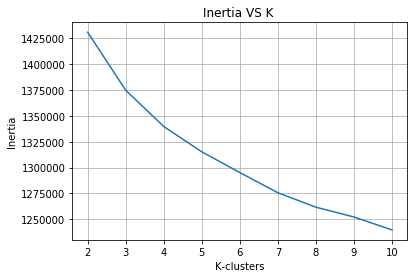

In [0]:
#https://www.geeksforgeeks.org/ml-determine-the-optimal-value-of-k-in-k-means-clustering/from sklearn.cluster import KMeans


from sklearn.cluster import KMeans
vectorizer = CountVectorizer(min_df = 1000)
X =vectorizer.fit_transform(preprocessed_reviews)
k =[2,3,4,5,6,7,8,9,10]
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_jobs=-1)
    model.fit(X)
    inertia.append(model.inertia_)
    
#finding best k using elbow method    
plt.plot(k, inertia)
plt.xlabel('K-clusters')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()


In [0]:
# At k=4 there is a point of inflection
k=4
model=KMeans(n_clusters=4, n_jobs=-1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [0]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/


cluster_1, cluster_2, cluster_3, cluster_4 =[],[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i] == 1:
        cluster_2.append(preprocessed_reviews[i])
    elif model.labels_[i] == 2:
        cluster_3.append(preprocessed_reviews[i])
    else:
        cluster_4.append(preprocessed_reviews[i])
    
 
            

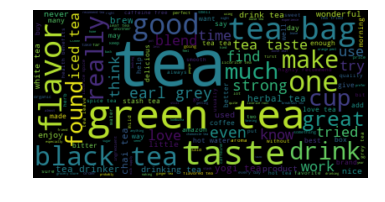

In [0]:
#for cluster 1
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

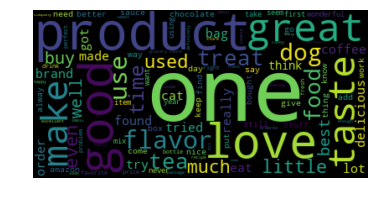

In [0]:
#for cluster 2
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

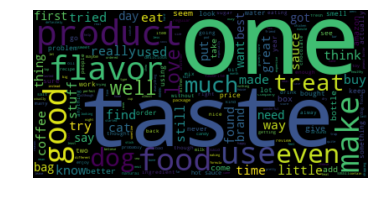

In [0]:
#for cluster 3
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

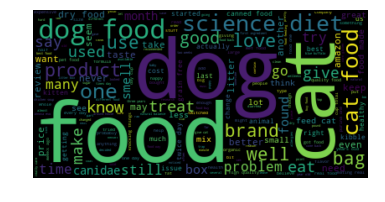

In [0]:
#for cluster 4
data=''
for i in cluster_4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [0]:
#Intialize tfidf vectorizer
tfidf_vect = TfidfVectorizer(min_df = 500)
X_train = tfidf_vect.fit_transform(preprocessed_reviews)

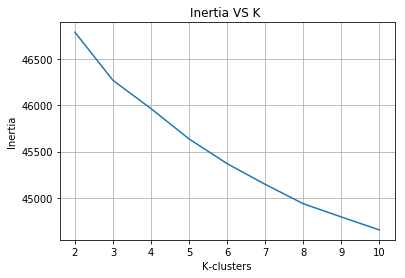

In [0]:
k =[2,3,4,5,6,7,8,9,10]
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_jobs=-1)
    model.fit(X_train )
    inertia.append(model.inertia_)
    
#finding best k using elbow method    
plt.plot(k, inertia)
plt.xlabel('K-clusters')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [0]:
#At k=3 there is a point of inflection
k=3
model=KMeans(n_clusters=3, n_jobs=-1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [0]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/


cluster_1, cluster_2, cluster_3=[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i] == 1:
        cluster_2.append(preprocessed_reviews[i])
    else:
        cluster_3.append(preprocessed_reviews[i])
    


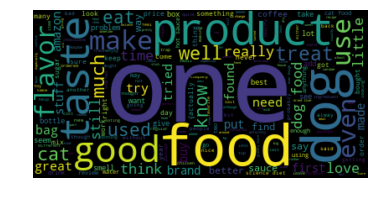

In [0]:
#for cluster 1
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

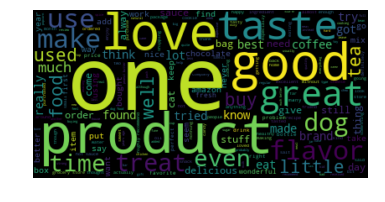

In [0]:
#for cluster 2
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

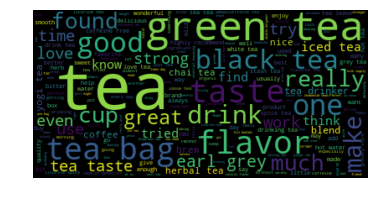

In [0]:
#for cluster 3
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [0]:
list_of_sentance_train=[]
for sentance in preprocessed_reviews:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 50000/50000 [02:46<00:00, 299.58it/s]


50000
50


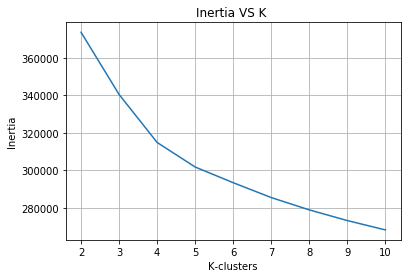

In [0]:
k=[2,3,4,5,6,7,8,9,10]
X_train=sent_vectors_train
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_jobs=-1)
    model.fit(X_train)
    inertia.append(model.inertia_)
#finding best k using elbow method    
plt.plot(k, inertia)
plt.xlabel('K-clusters')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [0]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

cluster_1, cluster_2, cluster_3=[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i] == 1:
        cluster_2.append(preprocessed_reviews[i])
    else:
        cluster_3.append(preprocessed_reviews[i])


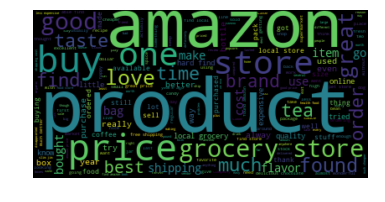

In [0]:
#for cluster 1
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

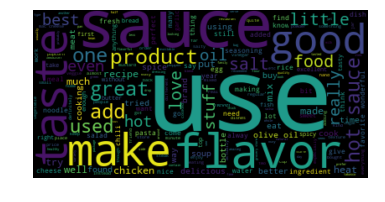

In [0]:
#for cluster 2
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

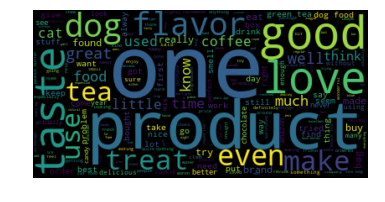

In [0]:
#for cluster 3
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
list_of_sentance_train=[]
for sentance in preprocessed_reviews:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(preprocessed_reviews)
tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 50000/50000 [03:01<00:00, 275.82it/s]


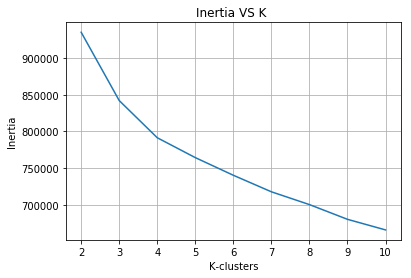

In [0]:
k=[2,3,4,5,6,7,8,9,10]
X_train =tfidf_sent_vectors_train
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_jobs=-1)
    model.fit(X_train)
    inertia.append(model.inertia_)
#finding best k using elbow method    
plt.plot(k, inertia)
plt.xlabel('K-clusters')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [0]:
#we can see that at k=4 there is a point of inflection
model=KMeans(n_clusters=4, n_jobs=-1)
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [0]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

cluster_1, cluster_2, cluster_3, cluster_4=[],[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i] == 1:
        cluster_2.append(preprocessed_reviews[i])
    elif model.labels_[i] == 2:
        cluster_3.append(preprocessed_reviews[i])
    else:
        cluster_4.append(preprocessed_reviews[i])


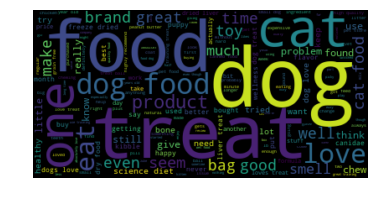

In [0]:
#for cluster 1
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

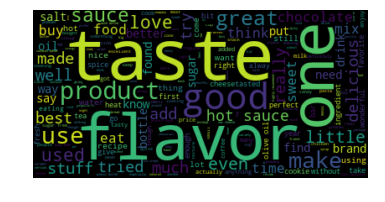

In [0]:
#for cluster 2
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

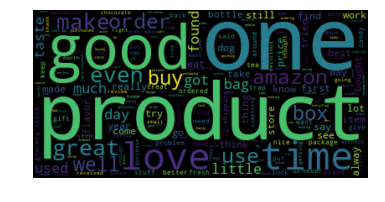

In [0]:
#for cluster 3
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

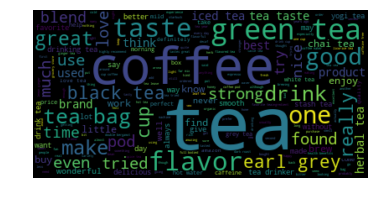

In [0]:
#for cluster 4
data=''
for i in cluster_4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

### Selecting 5k reviews for agglomerative clustering

In [0]:
preprocessed_reviews=preprocessed_reviews[:5000]

In [0]:
list_of_sentance_train=[]
for sentance in preprocessed_reviews:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 5000/5000 [00:10<00:00, 464.76it/s]


5000
50


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

In [0]:
from sklearn.cluster import AgglomerativeClustering
X_train =sent_vectors_train
model=AgglomerativeClustering(n_clusters=2)
model.fit(X_train)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x000002DC2DA3AEA0>)

## for k=2

In [0]:
cluster1,cluster2=[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(preprocessed_reviews[i])
    else:
        cluster2.append(preprocessed_reviews[i])

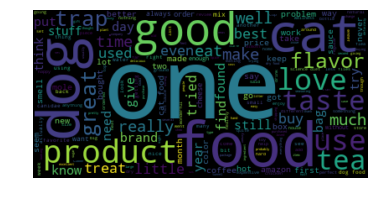

In [0]:
#for cluster 1
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

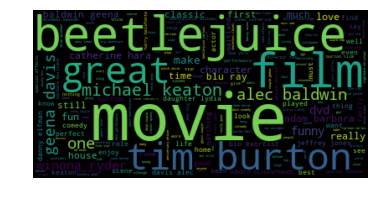

In [0]:
#for cluster 2
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## for k=5

In [0]:
from sklearn.cluster import AgglomerativeClustering
X_train =sent_vectors_train
model=AgglomerativeClustering(n_clusters=5)
model.fit(X_train)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x000002DC2DA3AEA0>)

In [0]:
cluster_1,cluster_2,cluster_3,cluster_4,cluster_5=[],[],[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i] == 1:
        cluster_2.append(preprocessed_reviews[i])
    elif model.labels_[i] == 2:
        cluster_3.append(preprocessed_reviews[i])
    elif model.labels_[i] == 3:
        cluster_4.append(preprocessed_reviews[i])
    else :
        cluster_5.append(preprocessed_reviews[i])

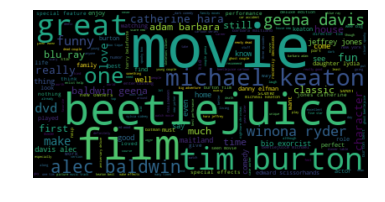

In [0]:
#for cluster 1
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

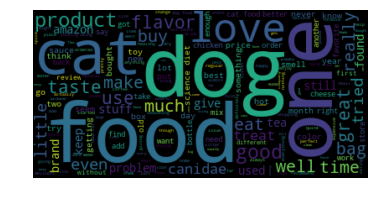

In [0]:
#for cluster 2
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

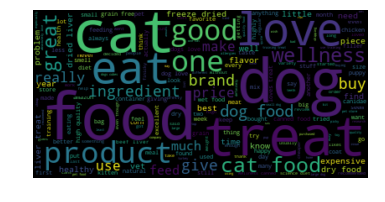

In [0]:
#for cluster 3
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

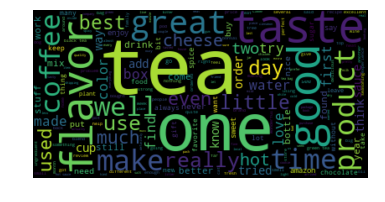

In [0]:
#for cluster 4
data=''
for i in cluster_4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

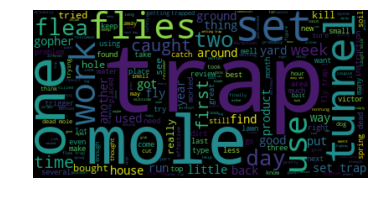

In [0]:
#for cluster 5
data=''
for i in cluster_5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
list_of_sentance_train=[]
for sentance in preprocessed_reviews:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(preprocessed_reviews)


tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:13<00:00, 371.35it/s]


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

### FOR K=2

In [0]:
from sklearn.cluster import AgglomerativeClustering
X_train =tfidf_sent_vectors_train
model=AgglomerativeClustering(n_clusters=2)
model.fit(X_train)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x000002DC2DA3AEA0>)

In [0]:
cluster_1,cluster_2=[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster_1.append(preprocessed_reviews[i])
    else:
        cluster_2.append(preprocessed_reviews[i])

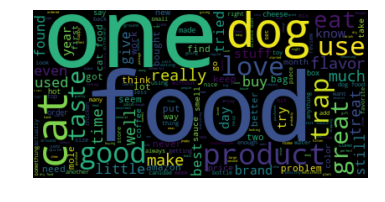

In [0]:
#for cluster 1
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

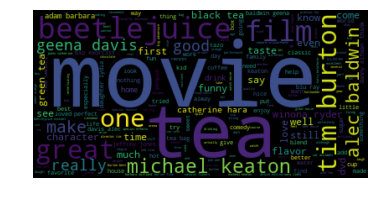

In [0]:
#for cluster 2
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### FOR K=5

In [0]:
from sklearn.cluster import AgglomerativeClustering
X_train =tfidf_sent_vectors_train
model=AgglomerativeClustering(n_clusters=5)
model.fit(X_train)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x000002DC2DA3AEA0>)

In [0]:
cluster_1,cluster_2,cluster_3,cluster_4,cluster_5=[],[],[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i] == 1:
        cluster_2.append(preprocessed_reviews[i])
    elif model.labels_[i] == 2:
        cluster_3.append(preprocessed_reviews[i])
    elif model.labels_[i] == 3:
        cluster_4.append(preprocessed_reviews[i])
    else :
        cluster_5.append(preprocessed_reviews[i])

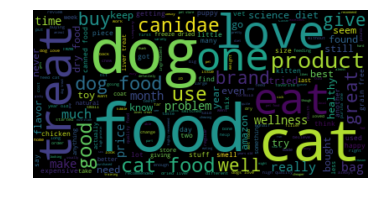

In [0]:
#for cluster 1
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

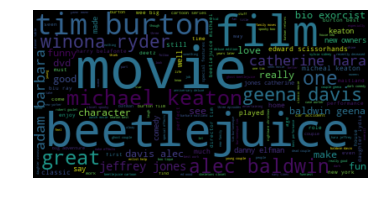

In [0]:
#for cluster 2
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

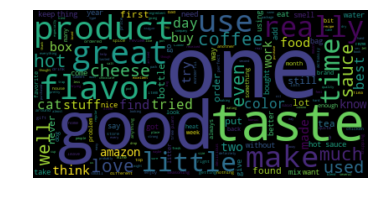

In [0]:
#for cluster 3
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

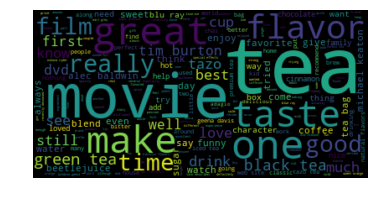

In [0]:
#for cluster 4
data=''
for i in cluster_4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

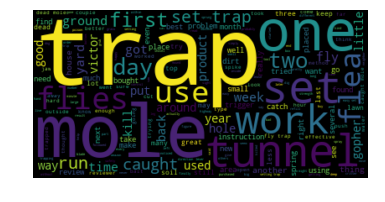

In [0]:
#for cluster 5
data=''
for i in cluster_5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [0]:
preprocessed_reviews=preprocessed_reviews[:5000]
list_of_sentance_train=[]
for sentance in preprocessed_reviews:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 5000/5000 [00:10<00:00, 463.93it/s]


5000
50


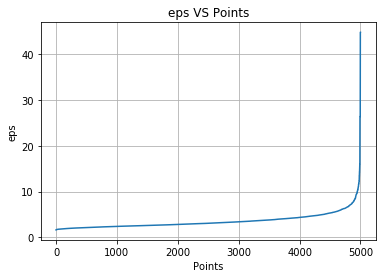

In [0]:
min_points = 100
from sklearn.preprocessing import StandardScaler
data=StandardScaler().fit_transform(sent_vectors_train)
# Computing distances of nth-nearest neighbours
distance=[]
for x in data:
    value=np.sort(np.sum((data-x)**2,axis=1),axis=None)
    distance.append(value[min_points])
final_eps=np.sqrt(np.array(distance))    

sorted_dist = np.sort(final_eps)
points = [point for point in range(len(sent_vectors_train))]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_dist)
plt.xlabel('Points')
plt.ylabel('eps')
plt.title('eps VS Points')
plt.grid()
plt.show()



point of inflexion is at eps=8

In [0]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=8, n_jobs=-1)
model.fit(data)
print('No of clusters: ',len(set(model.labels_)))
print('Cluster are ignoring (-1 for noise ): ',set(model.labels_))


No of clusters:  3
Cluster are ignoring (-1 for noise ):  {0, 1, -1}


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [0]:
ignoring -1 as it is for noise


In [0]:
cluster_1,cluster_2=[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster_1.append(preprocessed_reviews[i])
    else:
        cluster_2.append(preprocessed_reviews[i])
    

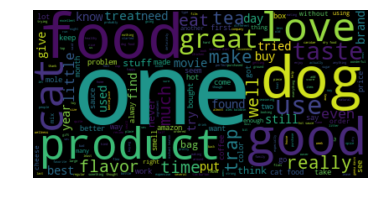

In [0]:
#for cluster 1
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

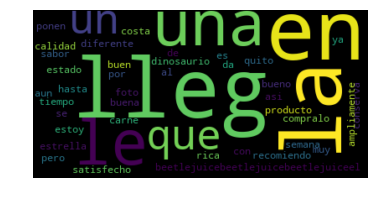

In [0]:
#for cluster 2
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
list_of_sentance_train=[]
for sentance in preprocessed_reviews:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(preprocessed_reviews)


tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:13<00:00, 364.15it/s]


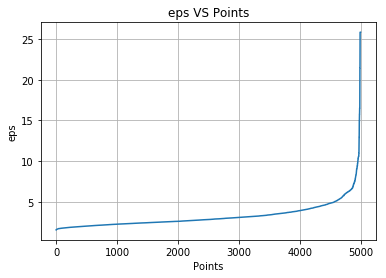

In [0]:
min_points = 100
from sklearn.preprocessing import StandardScaler
data=StandardScaler().fit_transform(tfidf_sent_vectors_train)
# Computing distances of nth-nearest neighbours
distance=[]
for x in data:
    value=np.sort(np.sum((data-x)**2,axis=1),axis=None)
    distance.append(value[min_points])
final_eps=np.sqrt(np.array(distance))    

sorted_dist = np.sort(final_eps)
points = [point for point in range(len(tfidf_sent_vectors_train))]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_dist)
plt.xlabel('Points')
plt.ylabel('eps')
plt.title('eps VS Points')
plt.grid()
plt.show()


In [0]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=7, n_jobs=-1)
model.fit(data)
print('No of clusters: ',len(set(model.labels_)))
print('Cluster are ignoring (-1 for noise ): ',set(model.labels_))


No of clusters:  4
Cluster are ignoring (-1 for noise ):  {0, 1, 2, -1}


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

In [0]:
cluster_1,cluster_2,cluster_3=[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster_1.append(preprocessed_reviews[i])
    elif model.labels_[i] == 1:
        cluster_2.append(preprocessed_reviews[i])
    else:
        cluster_3.append(preprocessed_reviews[i])
   

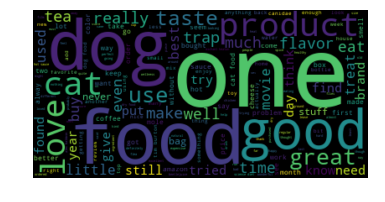

In [0]:
#for cluster 1
data=''
for i in cluster_1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

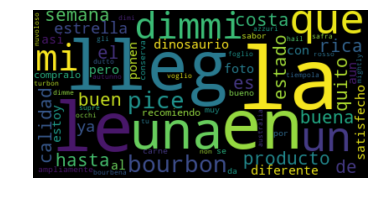

In [0]:
#for cluster 2
data=''
for i in cluster_2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

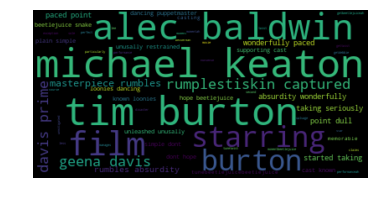

In [0]:
#for cluster 3
data=''
for i in cluster_3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# [6] Conclusions

In [0]:
#http://zetcode.com/python/prettytable/


from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "ALGO", "BEST_K" ]
x.add_row(["BOW","K-MEANS",4])
x.add_row(["TFIDF","K-MEANS", 3])
x.add_row(["AVG W2V","K-MEANS", 3])
x.add_row(["TFIDF W2V", "K-MEANS",4])
print(x)


z = PrettyTable()
z.field_names = ["Vectorizer", "ALGO", "EPS" ]
z.add_row(["AVG W2V","DBSCAN", 8])
z.add_row(["TFIDF W2V", "DBSCAN",7])


print(z)

+------------+---------+--------+
| Vectorizer |   ALGO  | BEST_K |
+------------+---------+--------+
|    BOW     | K-MEANS |   4    |
|   TFIDF    | K-MEANS |   3    |
|  AVG W2V   | K-MEANS |   3    |
| TFIDF W2V  | K-MEANS |   4    |
+------------+---------+--------+
+------------+--------+-----+
| Vectorizer |  ALGO  | EPS |
+------------+--------+-----+
|  AVG W2V   | DBSCAN |  8  |
| TFIDF W2V  | DBSCAN |  7  |
+------------+--------+-----+
